# Regression for Car price Prediction

AutoScout24 provided us with a dump of their productive database. You are assigned to train a prediction model for the selling price of second-hand cars, which in the future shall enable the platform to automatically suggest an adequate selling price whenever a customer uploads a new sale advertisement.

<a href="https://www.autoscout24.ch/de"><img src="https://www.autoscout24.ch/MVC/Content/desktop/img/autoscout24-logo-og.png" height="30%" width="30%"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tqdm.notebook import tqdm
import ipywidgets as widgets
%matplotlib inline

### Load the data

In [2]:
df = pd.read_csv("cars.csv", parse_dates=['Registration'])

In [3]:
df.shape

(55208, 12)

In [4]:
df.head(n=5)

,Name,Price,Mileage,Registration,Color,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year
0,MERCEDES-BENZ SL 500,44800,27600,1996-10-01,anthrazit,2,320,4973,2,8,5,1996
1,BMW 740iL,22800,18300,1999-05-01,anthrazit,4,286,4398,5,8,5,1999
2,AUDI A8 4.2 FSI quattro,183710,650,2008-08-01,anthrazit,5,350,4172,5,8,6,2008
3,OPEL Zafira 2.2i Cosmo,19900,32000,2006-02-01,anthrazit,5,150,2198,7,4,6,2006
4,VOLVO V70 D5 AWD A,18999,118000,2003-02-01,anthrazit,5,163,2401,5,5,5,2003


### Data Preparation

Here we set datatypes and indices, split fields, maybe join tables if we have multiple input sources and so on. In this exercise, the data is mostly clean and well-prepared. All we have to do is set the datatypes. Please note that you can do this directly with pd.read_csv if you want (as shown above with the `parse_date` argument).

##### Handle categorical variables

One variable is categorical. Encode it as Pandas datatype `categorical` (you can use [pd.DataFrame.astype()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.astype.html)) and print the dtypes afterwards.

In [5]:
df.Color = df.Color.astype("category")
df.dtypes

Name                    object
Price                    int64
Mileage                  int64
Registration    datetime64[ns]
Color                 category
Doors                    int64
Horsepower               int64
EngineSize               int64
Seats                    int64
Cylinders                int64
Gears                    int64
Year                     int64
dtype: object

### Data Analysis and Quality Assessment

To get to know the data and to get a feeling for it, it is important to examine it before doing any modelling. Data Cleaning and Data Analysis (also called Explorative Data Analysis) are a large part of Machine Learning.

##### Duplicates

Let's begin by checking for duplicate rows. With the data at hand, exact duplicates should not occur. While it is of course possible that two cars of the same maker and model are being sold, the mileage and registration probably would not match. Exact duplicates thus hint at an anomaly from entering, processing or extracting the data (which is in fact very common).

> Find out if there are rows that are exact duplicates. If there are, examine and possibly drop them. You can use [pd.DataFrame.duplicated()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.duplicated.html) and [pd.DataFrame.drop_duplicates()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop_duplicates.html).

In [6]:
df.duplicated().any()

True

In [7]:
df[df.duplicated(keep=False)]

,Name,Price,Mileage,Registration,Color,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year
657,FIAT Punto 1.4 Easy,16300,10,2013-01-01,anthrazit,5,78,1368,5,4,5,2013
658,FIAT Punto 1.4 Easy,16300,10,2013-01-01,anthrazit,5,78,1368,5,4,5,2013
759,SUZUKI Swift 1.2i 16V GL Top,15900,50,2013-03-01,anthrazit,5,94,1242,5,4,5,2013
760,SUZUKI Swift 1.2i 16V GL Top,15900,50,2013-03-01,anthrazit,5,94,1242,5,4,5,2013
761,SUZUKI Swift 1.2i 16V GL Top,15900,50,2013-03-01,anthrazit,5,94,1242,5,4,5,2013
...,...,...,...,...,...,...,...,...,...,...,...,...
55163,SKODA SUPERB 1.4 TSI Active Fresh,23800,100,2013-06-01,weiss,5,125,1390,5,4,6,2013
55189,HYUNDAI i30 1.4 Pica Swiss,16990,1,2013-01-01,weiss,5,99,1396,5,4,6,2013
55190,HYUNDAI i30 1.4 Pica Swiss,16990,1,2013-01-01,weiss,5,99,1396,5,4,6,2013
55191,HYUNDAI i30 1.4 Pica Swiss,16990,1,2013-01-01,weiss,5,99,1396,5,4,6,2013


In [8]:
df = df.drop_duplicates()
df.duplicated().any()

False

##### Null values

> Now check for null values.

In [9]:
df.isna().any()
# isnull() is an alias for isna()

Name            False
Price           False
Mileage         False
Registration    False
Color           False
Doors           False
Horsepower      False
EngineSize      False
Seats           False
Cylinders       False
Gears           False
Year            False
dtype: bool

##### Data ranges

> Check if the date ranges make sense.

In [10]:
df.Year.min(), df.Year.max()

(1900, 2014)

In [11]:
df.Registration.dt.year.min(), df.Registration.dt.year.max()

(1900, 2014)

Even though that could be (the [oldest car](https://en.wikipedia.org/wiki/History_of_the_automobile) is quite a bit older than 1900), it is unlikely that cars from 1900 will be sold on AutoScout24. We need to examine ...

But first, it is also a bit suspicious that both the Registration and the Year show the same range. Maybe we have redundant information that we can drop?

##### Redundant data

> Check whether the year from *Registration* and the *Year* column are identical. You can use the [.dt accessor](https://pandas.pydata.org/pandas-docs/stable/basics.html#basics-dt-accessors) to get the year from the registration date.

In [12]:
df[df.Year != df.Registration.dt.year].any().any()

False

> Next, check if there is variation in the day of the Registration date. You can use [.nunique()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.nunique.html) or [.value_counts()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html) for this.

In [13]:
df.Registration.dt.day.value_counts()

1    54738
Name: Registration, dtype: int64

So the *Registration* column contains the same year that we also have in the *Year* column and an additional month. The day is always 1.

To simplify the rest of this exercise, let's only keep the *Year* column. For more detailed analysis, you might want to keep the month, however.

> Drop the *Registration* column.

In [14]:
df = df.drop("Registration", axis="columns")

##### Data ranges again

Now back to these very old cars. 

> Sort the dataframe so that the oldest cars show first and list the first 5 entries.

In [15]:
df.sort_values(by="Year").head(5)

,Name,Price,Mileage,Color,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year
47125,HYUNDAI i30 1.6 GDI STYLE,29130,10,silber,5,135,1591,5,4,6,1900
22513,MERCEDES-BENZ SL-CLASS 280 Pagode,47800,65000,rot,2,170,2778,4,6,4,1968
22791,SUZUKI Samurai Wagon EFI,6700,60000,rot,3,69,1298,4,4,5,1985
4108,SUZUKI Samurai Wagon EFI,6900,51000,blau,3,69,1298,4,4,5,1985
23209,SUZUKI Samurai Wagon 30 Kmh,6900,45000,rot,3,69,1298,4,4,5,1986


Googling these, it looks like only the first row has an invalid Year and the remaining are ok. 

>Select the row with year 1900 and drop it.

In [16]:
df = df.drop(47125, axis="index")

Now we calculate basic statistics and check if they are reasonable.

In [17]:
df.describe()

,Price,Mileage,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year
count,54737.000000,5.473700e+04,54737.000000,54737.000000,54737.000000,54737.000000,54737.000000,54737.000000,54737.000000
mean,29810.030473,5.292118e+04,4.340172,171.398889,2114.674754,4.806493,4.559749,5.797651,2008.689881
std,30787.510715,5.993429e+04,1.047174,93.174433,961.494887,0.911259,1.365250,0.857746,4.407135
min,300.000000,0.000000e+00,2.000000,40.000000,599.000000,2.000000,2.000000,1.000000,1968.000000
25%,12400.000000,1.500000e+03,4.000000,112.000000,1560.000000,5.000000,4.000000,5.000000,2006.000000
50%,21900.000000,2.987500e+04,5.000000,150.000000,1968.000000,5.000000,4.000000,6.000000,2010.000000
75%,36950.000000,8.975000e+04,5.000000,200.000000,2290.000000,5.000000,4.000000,6.000000,2012.000000
max,698000.000000,1.530000e+06,6.000000,777.000000,8285.000000,14.000000,12.000000,8.000000,2014.000000


Do you see anything else suspicious? 
> Feel free to examine further.

##### Outliers

Let's next take care of outliers. As we have seen in the lecture, outliers can affect the performance of algorithms that are based on distance or similarity.

We create a boxplot for the four numerical columns.

Price            AxesSubplot(0.125,0.53;0.352273x0.35)
Mileage       AxesSubplot(0.547727,0.53;0.352273x0.35)
Horsepower       AxesSubplot(0.125,0.11;0.352273x0.35)
EngineSize    AxesSubplot(0.547727,0.11;0.352273x0.35)
dtype: object

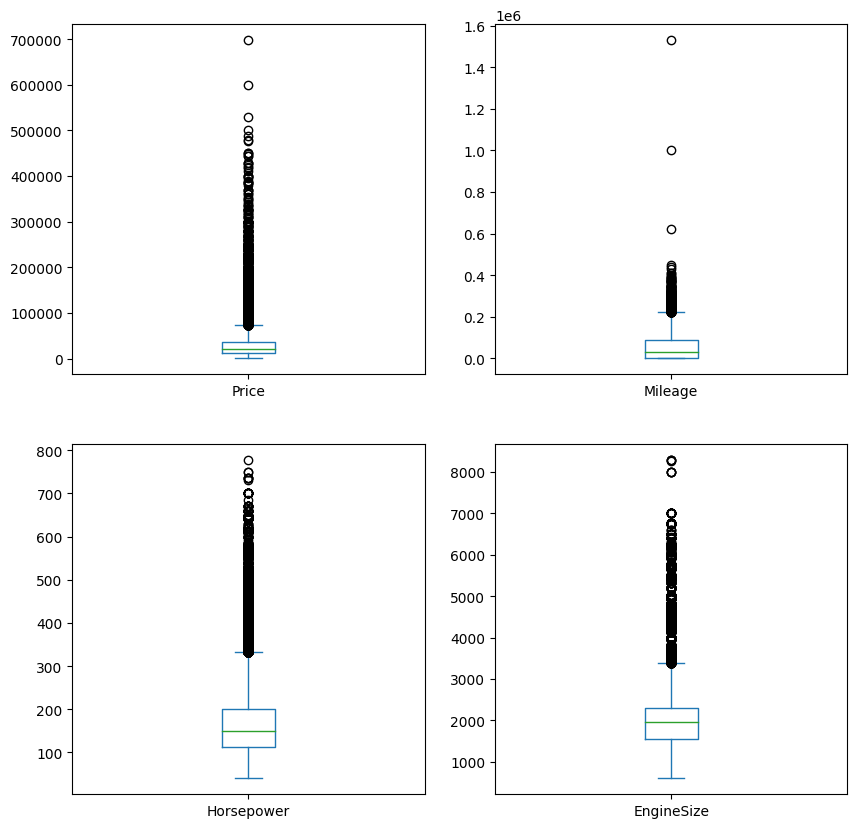

In [18]:
numerical_cols = ['Price', 'Mileage', 'Horsepower', 'EngineSize']
df.loc[:, numerical_cols].plot(kind='box', subplots=True, layout=(2, 2), figsize=(10, 10), sharex=False)

According to the rule that values at least 1.5 * IQR above the 3rd quartile or below the 1st quartile are considered outliers, we have many of those (the circles in the boxplot). However, as we already have checked the validity of the data ranges, we assume that these do not signify a problem with the data (such as wrongly entered data), but are in fact valid, but extreme samples.

For algorithms that are heavily influenced by outliers (such as Linear Regression), it might be best to remove them anyway. But this is something that has to be evaluated with experiments and cross-validation. Furthermore, it is very important that statistics such as the mean for normalisation and the IQR for outlier removal are computed on the training set only (meaning *after* a cross-validation split and not *before*). 

We will skip outlier removal for now and look at it again in detail in one of the next exercises. The following code is just given for reference. 

In [19]:
# The following code can be used to calculate an upper bound.
# If applied, this bound must be calculated only on the training set, not on the complete dataset.
# In a dataset where there are outliers above as well as below the two quartiles, the lower bound
# would have to be calculated accordingly
if False:
    q3 = df.loc[:, numerical_cols].describe().loc['75%']
    iqr = q3 - df.loc[:, numerical_cols].describe().loc['25%']
    upper_boundary = q3 + 1.5*iqr
    upper_boundary

In [20]:
# And here the outliers are removed
if False:
    df = df[(df.Price <= upper_boundary.Price) &
            (df.Mileage <= upper_boundary.Mileage) &
            (df.Horsepower <= upper_boundary.Horsepower) &
            (df.EngineSize <= upper_boundary.EngineSize)]

##### Data distribution and pairwise relation

Lastly, let's look at the distributions and the pairwise relations. 

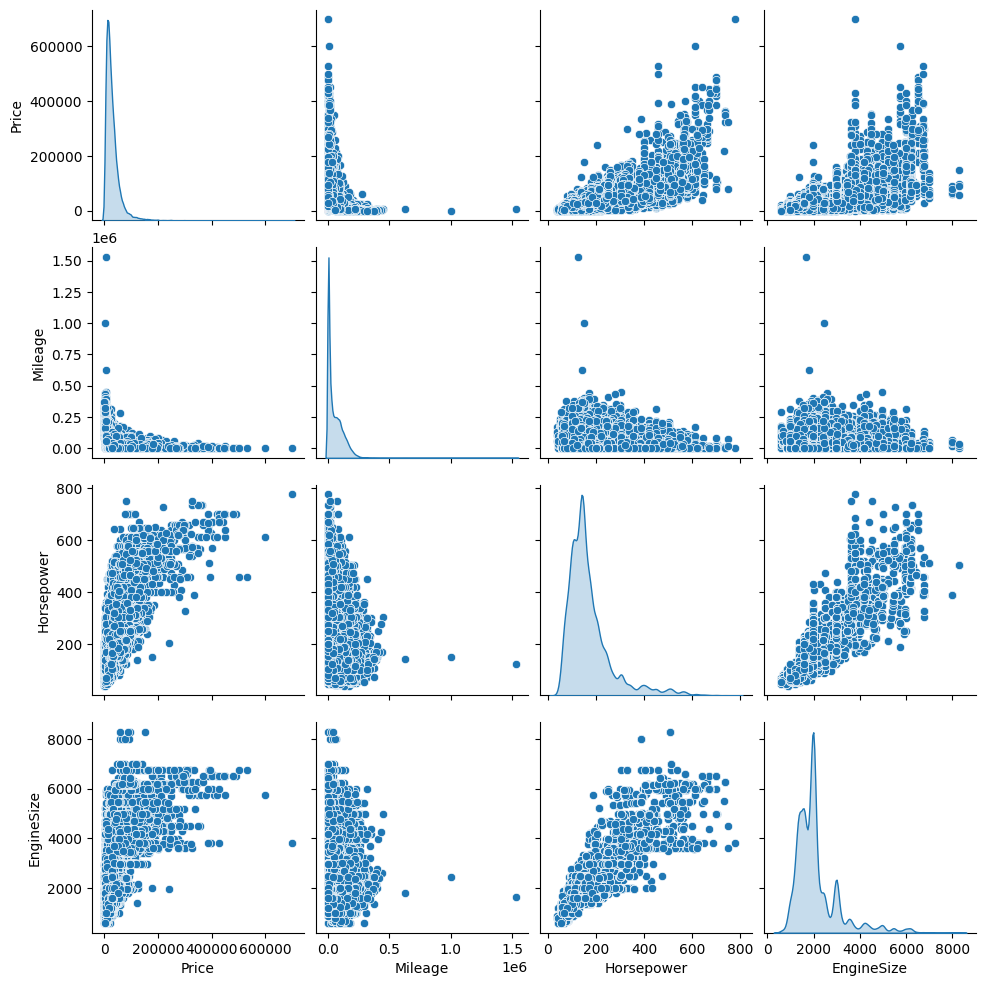

In [21]:
sns.pairplot(df.loc[:, numerical_cols], diag_kind = "kde", kind = "scatter")

# or with just pandas:
# pd.plotting.scatter_matrix(df.loc[:, numerical_cols], diagonal='kde')

We see that all distributions are right-skewed. It might be beneficial to transform them, another experiment that would have to be evaluated with cross-validation. We also see the expected linear relationship between Horsepower and EngineSize. Something else to expect which is not supported by the data at hand could be a linear relationship between Mileage and Price.

And certain outliers are also visible. Let's remove them now.

>Remove the 3 elements with the largest Mileage.

In [22]:
df.Mileage.sort_values(ascending=False).head(5)

17010    1530000
7734      999999
47002     623750
4668      450000
7808      437899
Name: Mileage, dtype: int64

In [23]:
df = df.drop([17010, 7734, 47002], axis="index")

>Remove the 2 samples with the largest Price.

In [24]:
df.Price.sort_values(ascending=False).head(5)

44369    698000
24720    600000
29735    529999
43004    499999
31720    489000
Name: Price, dtype: int64

In [25]:
df = df.drop([44369, 24720], axis="index")

Remove the 8 samples with the largest EngineSize.

In [26]:
df.EngineSize.sort_values(ascending=False).head(10)

23306    8285
29763    8285
23294    8285
22503    8277
26905    7990
24039    7990
11359    7990
23281    7990
49852    7011
54397    7011
Name: EngineSize, dtype: int64

In [27]:
df = df.drop(df.index[df.EngineSize > 7500], axis="rows")

Okay, let's leave it at that.

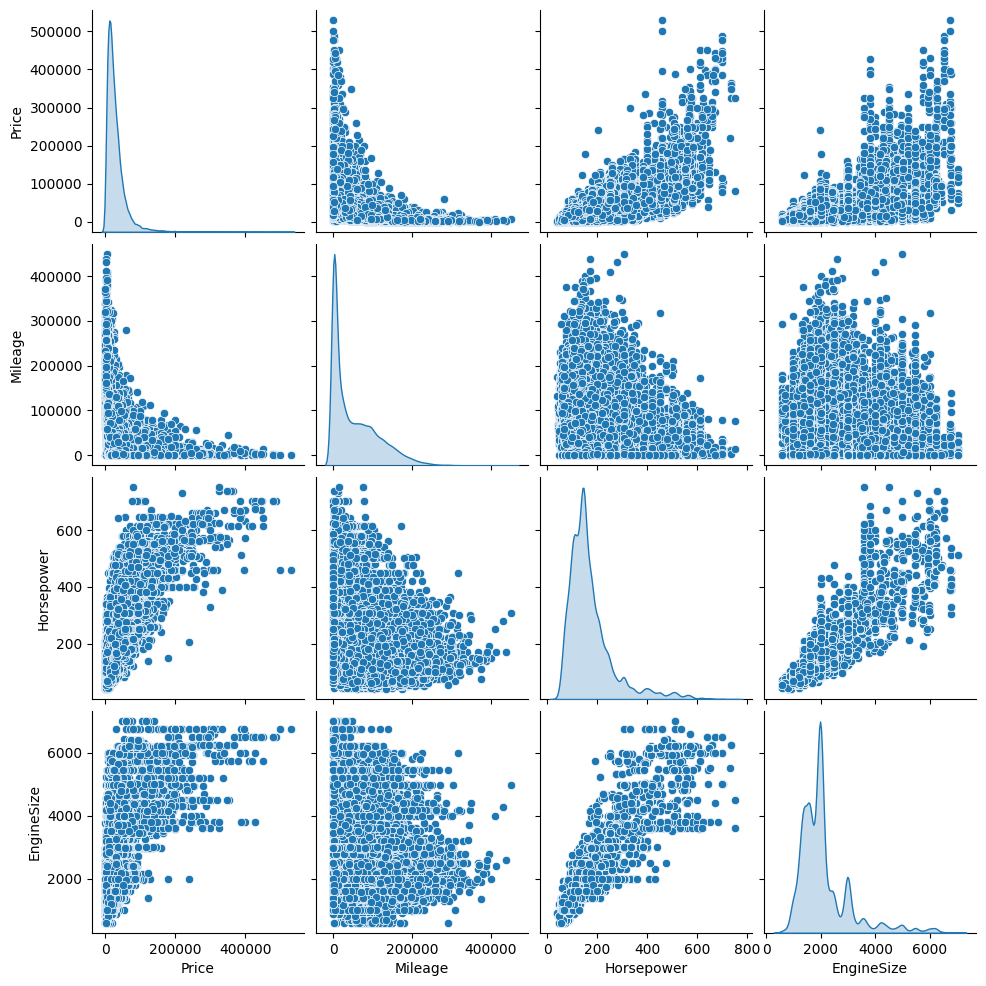

In [28]:
sns.pairplot(df.loc[:, numerical_cols], diag_kind = "kde", kind = "scatter")

## Price prediction

Ok, now that we have done our data quality assessment, let's dive into the [Scikit-learn](https://scikit-learn.org/) toolkit. Our goal is to fit a model which is able to predict the price of a car. We are going to use the **K-Nearest Neighbor (KNN)** algorithm for this regression problem.

### Feature Engineering
Before we can train our model, we have to do some feature engineering. Let's take a look at our dataset again.

In [29]:
df.head()

,Name,Price,Mileage,Color,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year
0,MERCEDES-BENZ SL 500,44800,27600,anthrazit,2,320,4973,2,8,5,1996
1,BMW 740iL,22800,18300,anthrazit,4,286,4398,5,8,5,1999
2,AUDI A8 4.2 FSI quattro,183710,650,anthrazit,5,350,4172,5,8,6,2008
3,OPEL Zafira 2.2i Cosmo,19900,32000,anthrazit,5,150,2198,7,4,6,2006
4,VOLVO V70 D5 AWD A,18999,118000,anthrazit,5,163,2401,5,5,5,2003


Since we now actually use the categorical column, we need to transform it. Use [pd.get_dummies()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) and [pd.concat](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html) to [One-Hot encode](https://en.wikipedia.org/wiki/One-hot) the *Color* column (in the lecture, this is described in the section *Vector Space Model*).

> Then, drop the original *Colors* column.

In [30]:
df = pd.concat([df, pd.get_dummies(df.Color)], axis="columns")
df = df.drop("Color", axis="columns")
df.head()

,Name,Price,Mileage,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year,...,grau,grün,orange,pink,rot,schwarz,silber,türkis,violett,weiss
0,MERCEDES-BENZ SL 500,44800,27600,2,320,4973,2,8,5,1996,...,0,0,0,0,0,0,0,0,0,0
1,BMW 740iL,22800,18300,4,286,4398,5,8,5,1999,...,0,0,0,0,0,0,0,0,0,0
2,AUDI A8 4.2 FSI quattro,183710,650,5,350,4172,5,8,6,2008,...,0,0,0,0,0,0,0,0,0,0
3,OPEL Zafira 2.2i Cosmo,19900,32000,5,150,2198,7,4,6,2006,...,0,0,0,0,0,0,0,0,0,0
4,VOLVO V70 D5 AWD A,18999,118000,5,163,2401,5,5,5,2003,...,0,0,0,0,0,0,0,0,0,0


And we still have that name column, which isn't really useful. One possibility would be to treat it as a categorical variable.
>Let's check how many different car names that would yield.

In [31]:
df.Name.nunique()

14683

Too many. If we want to use this information, we need to either make bins or dissect the column into subfields. This is a bit of work, so to keep it simple, extract the brand from the beginning of the string and use this as a feature. This is a simplification, and it doesn't get everything right, e.g. brand names with a space such as 'LAND ROVER' or 'ASTON MARTIN' are truncated. But for the sake of the exercise, let's be happy with that.

>Use the [.str accessor](https://pandas.pydata.org/pandas-docs/stable/text.html#splitting-and-replacing-strings) to split the Name column, [map](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) with a lambda expression to take only the brand and assign to a new column called *Brand*. Then drop the Name column.

In [32]:
df["Brand"] = df.Name.str.split(" ").map(lambda x: x[0])
df = df.drop("Name", axis="columns")
df.head()

,Price,Mileage,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year,anthrazit,...,grün,orange,pink,rot,schwarz,silber,türkis,violett,weiss,Brand
0,44800,27600,2,320,4973,2,8,5,1996,1,...,0,0,0,0,0,0,0,0,0,MERCEDES-BENZ
1,22800,18300,4,286,4398,5,8,5,1999,1,...,0,0,0,0,0,0,0,0,0,BMW
2,183710,650,5,350,4172,5,8,6,2008,1,...,0,0,0,0,0,0,0,0,0,AUDI
3,19900,32000,5,150,2198,7,4,6,2006,1,...,0,0,0,0,0,0,0,0,0,OPEL
4,18999,118000,5,163,2401,5,5,5,2003,1,...,0,0,0,0,0,0,0,0,0,VOLVO


In [33]:
df.Brand.nunique()

70

Now we have a new categorical variable. Again we have to [One-Hot encode](https://en.wikipedia.org/wiki/One-hot) this column.

In [34]:
df = pd.concat([df, pd.get_dummies(df.Brand)], axis="columns")
df = df.drop("Brand", axis="columns")

Now our Dataframe looks like this:

In [35]:
df.head()

,Price,Mileage,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Year,anthrazit,...,SMART,SSANG,SUBARU,SUZUKI,TATA,TOYOTA,TVR,VOLVO,VW,WIESMANN
0,44800,27600,2,320,4973,2,8,5,1996,1,...,0,0,0,0,0,0,0,0,0,0
1,22800,18300,4,286,4398,5,8,5,1999,1,...,0,0,0,0,0,0,0,0,0,0
2,183710,650,5,350,4172,5,8,6,2008,1,...,0,0,0,0,0,0,0,0,0,0
3,19900,32000,5,150,2198,7,4,6,2006,1,...,0,0,0,0,0,0,0,0,0,0
4,18999,118000,5,163,2401,5,5,5,2003,1,...,0,0,0,0,0,0,0,1,0,0


We probably have too many features in relation to the amount of data. So let's start by only using 5 features.
As a next step, we split the features from the target *(price)* we are going to predict.

In [36]:
feature_columns = ['Mileage', 'Year', 'Horsepower', 'Doors', 'schwarz']

In [37]:
X = df[feature_columns].values
# We convert it to float so we don't get a conversion warning when normalizing the data
X = X.astype("float") 
y = df.Price.values

#### Splitting the data
Split the data into a training and test set using the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. Use 20% of the data for the test set. Then print  the shapes of the resulting data sets and make sure the splitting was correct.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

X_train: (43779, 5)
X_test: (10945, 5)
y_train (43779,)
y_test (10945,)


### Baseline Model

To get an idea how good our model performs, it often makes sense to implement a baseline model. In our case the baseline model should just returns the median of the price. For that case we can use the [DummyRegressor]("https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html") from sklearn.

Instantiate a new DummyRegressor with the strategy `median`

In [39]:
dummy = DummyRegressor(strategy="median")

Now fit the model on the training data.

In [40]:
dummy.fit(X_train, y_train)

DummyRegressor(strategy='median')

Congrats, you have trained your first model (even though the model is pretty dumb :-))! Let's check how good the baseline model performs.

But first we need to make a prediction on the test set.

In [41]:
y_pred = dummy.predict(X_test)

We will measure the quality of our result with the [Mean Absolute Error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error). This means that we don't care whether we estimate a price as too high or too low, only the magnitude of the difference counts. We will also calculate the [Coefficient of Determination (R<sup>2</sup>) score](https://en.wikipedia.org/wiki/Coefficient_of_determination). Our goal is to minimize the MAE and to maximize the R<sup>2</sup> score.

Calculate the [Mean Absolute Error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error) for the predictions made on the test set. Implement it yourself instead of using the Scikit-Learn toolkit.

In [42]:
np.mean(np.abs(y_test - y_pred))

17789.46066697122

Scikit-Learn also provides the function [mean_absolute_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) so we don't have to implement it ourseleves.

In [43]:
mean_absolute_error(y_test, y_pred)

17789.46066697122

The R<sup>2</sup> score can be calculated using the Scikit-Learn function [r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html).

In [44]:
r2_score(y_test, y_pred)

-0.06545845877899592

### K-Nearest Neighbors (KNN)

Okay, our baseline model is pretty bad! Let's see if we can improve our performance with a KNN-model.

#### Normalize the data
When using the K-Nearest Neighbors algorithm it is important to normalize the data. We use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from Scikit-Learn which represents the Z-Score normalization.

In [73]:
print("Original", X_train[0])

Original [  50. 2013.  140.    5.    0.]


In [46]:
scaler = StandardScaler()

Now that we have instantiated the scaler, we could call the `fit` method, which will calculate the *variance* and *mean* per feature store it. We then call `transform` to apply the normalization to the data. 

In [47]:
# fit the scaler and then transform
scaler.fit(X_test, y_test)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
print("Mean per feature:", scaler.mean_)
print("Variance per feature", scaler.var_)

Mean per feature: [5.23524729e+04 2.00871192e+03 1.71165190e+02 4.33805391e+00
 2.69986295e-01]
Variance per feature [3.47217384e+09 1.92959976e+01 8.71854722e+03 1.10326181e+00
 1.97093696e-01]


In [49]:
print("Scaled", X_train[0])

Scaled [-0.88760858  0.97617781 -0.33377032  0.63020716 -0.6081425 ]


As we have measured the performance of the baseline model, we can start to use an actual machine learning model. We will use the [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) model.
Instantiate a new object of the `KNeighborsRegressor` model. Set the hyperparameter `n_neighbors` equal to 5. Then fit the model on the training data and calculate the metrics on the test set.

In [50]:
# Instantiate model
knr = KNeighborsRegressor(n_neighbors=5)

In [51]:
# Fit the model
knr.fit(X_train, y_train)

KNeighborsRegressor()

In [52]:
# Predict on the test set
y_pred = knr.predict(X_test)

In [53]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MAE:", mae)
print("r2:", r2)

MAE: 6190.921059844678
r2: 0.8400148562976952


## Hyperparameter Tuning

The KNeighborsRegressor has the hyperparameter `n_neighbors` that we would like to tune. As explained in the lecture you **should not use the test set** to tune the hyperparameters. Therefore we further split the training set into a validation set or use a k-fold cross-validation. 



#### Splitting the data
Split the original data into the following: 60% training data, 20% validation, 20% test data. Make sure the splitting is correct by checking the shapes.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print("X_train:", X_train.shape)
print("y_train", y_train.shape)
print("X_val", X_val.shape)
print("y_val", y_val.shape)
print("X_test:", X_test.shape)
print("y_test", y_test.shape)

X_train: (32834, 5)
y_train (32834,)
X_val (10945, 5)
y_val (10945,)
X_test: (10945, 5)
y_test (10945,)


#### Normalization
Again, apply z-normalization to the data

In [55]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

#### Manually select best parameter
Let's select the value for `n_neighbors` where we get the highest R<sup>2</sup> score.

In [56]:
@widgets.interact(k=widgets.IntSlider(
    value=1,
    min=1,
    max=12,
    step=1,
    description='n_neighbors:'))
def f(k):
    knr = KNeighborsRegressor(n_neighbors=k)
    knr.fit(X_train, y_train)
    y_pred = knr.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    print("K={} -> r2={}".format(k, r2))

interactive(children=(IntSlider(value=1, description='n_neighbors:', max=12, min=1), Output()), _dom_classes=(…

#### Automatically select best parameter
Now let's try different values for `n_neighbors` by looping through a list of possible values. We want to automatically select the parameter for `n_neighbors` which results in the highest R<sup>2</sup> score.

In [57]:
r2_scores = []
k_range = list(range(1, 13))
for k in tqdm(k_range):
    # START YOUR CODE
    knr = KNeighborsRegressor(n_neighbors=k)
    knr.fit(X_train, y_train)
    y_pred = knr.predict(X_val)
    r2 = r2_score(y_val, y_pred)

    r2_scores.append(r2)
    # END YOUR CODE
    print("K={} -> r2={}".format(k, r2))
    pass

idx = np.argmax(r2_scores)
best_k = k_range[idx]
max_r2 = np.max(r2_scores)
print("Best K:", best_k)
print("max r:", max_r2)

  0%|          | 0/12 [00:00<?, ?it/s]

K=1 -> r2=0.783412050193284
K=2 -> r2=0.8064588047448136
K=3 -> r2=0.8182888479573045
K=4 -> r2=0.8229764770045475
K=5 -> r2=0.8201715807691973
K=6 -> r2=0.8198151099223195
K=7 -> r2=0.8196096124509389
K=8 -> r2=0.8186519590099398
K=9 -> r2=0.8176631502220651
K=10 -> r2=0.8181369681817194
K=11 -> r2=0.818317591615703
K=12 -> r2=0.8190355262285456
Best K: 4
max r: 0.8229764770045475


We can now plot how the R<sup>2</sup> score changes when we increase K.

Text(0, 0.5, 'r2')

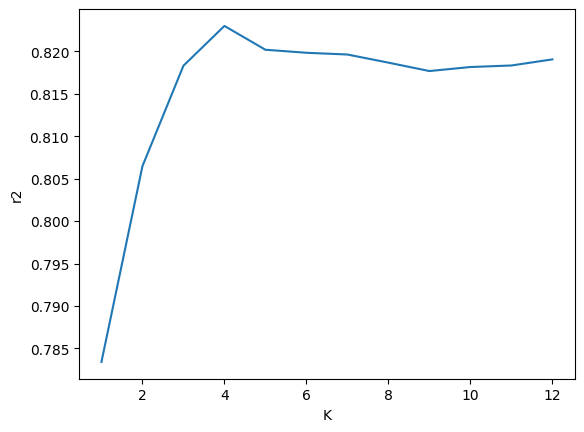

In [58]:
plt.plot(k_range, r2_scores)
plt.xlabel("K")
plt.ylabel("r2")

Now that we have found the our optimal number of neighbors, we can now finally evaluate how good our model performs on the test set. 

**Note**: Until now we should have never touched the test set. If we want to further improve our model after looking at the test data we would need to split the data again! Otherwise our result might be optimistically biased.

In [59]:
knr = KNeighborsRegressor(n_neighbors=best_k)
knr.fit(X_train, y_train)

y_pred = knr.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2: ", r2)

r2:  0.8365721854075524


### Cross-Validation

What we have done so far is a so called 1-fold cross-validation: We splitted our data into a training, test and validation set. Now we want to perform a k-fold cross validation.

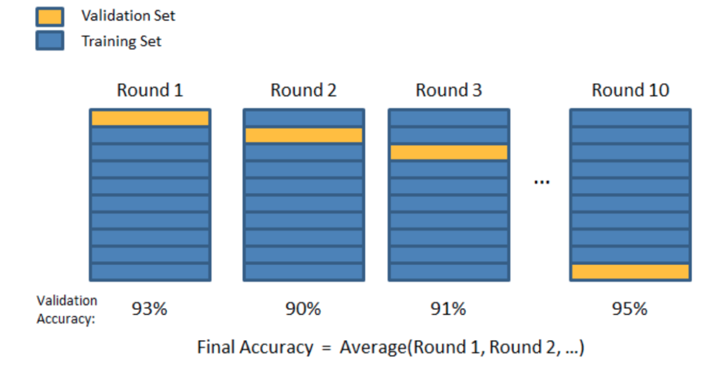

##### Splitting the data
When we do cross-validation we split our data set into a training and a test set and then split the training set during the cross-validation into a training and validation set.

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train:", X_train.shape)
print("y_train", y_train.shape)
print("X_test:", X_test.shape)
print("y_test", y_test.shape)

X_train: (43779, 5)
y_train (43779,)
X_test: (10945, 5)
y_test (10945,)


For applying cross-validation use the [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class from Sci-Kit learn to further split the training data into a training and validation set. Use the `split` method and don't forget to normalize your data.

In [61]:
def apply_cv(X, y, model, n_splits):
    y_trues = []
    y_preds = []
    # START YOUR CODE
    kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    for (train_index, val_index) in tqdm(kf.split(X)):
        X_train_cv, X_val_cv = X[train_index], X[val_index]
        y_train_cv, y_val_cv = y[train_index], y[val_index]

        X_train_cv = scaler.fit_transform(X_train_cv)
        X_val_cv = scaler.transform(X_val_cv)

        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_val_cv)

        y_trues.extend(y_val_cv.tolist())
        y_preds.extend(y_pred.tolist())

    # END YOUR CODE
    return y_trues, y_preds

We can now use our implemented method `apply_cv` to run the 10-fold cross-validation for our dataset.

In [62]:
y_trues, y_preds = apply_cv(X_train, y_train, model=knr, n_splits=10)
MAE = mean_absolute_error(y_trues, y_preds)
r2 = r2_score(y_trues, y_preds)
print("MAE:", MAE)
print("r2:", r2)

0it [00:00, ?it/s]

MAE: 6368.552987733845
r2: 0.8244916683380497


We have now implemented a simple cross-validation function. Let's use this function now for tuning the `n_neighbors` hyperparameter.

In [63]:
r2_scores = []
k_range = list(range(1, 13))
for k in tqdm(k_range):
    # START YOUR CODE
    knr = KNeighborsRegressor(n_neighbors=k)
    y_trues, y_preds = apply_cv(X_train, y_train, model=knr, n_splits=10)
    r2 = r2_score(y_trues, y_preds)

    r2_scores.append(r2)
    # END YOUR CODE
    print("K={} -> r2={}".format(k, r2))
    pass
    
idx = np.argmax(r2_scores)
best_k = k_range[idx]
max_r2 = np.max(r2_scores)
print("Best K:", best_k)
print("max r2:", max_r2)

  0%|          | 0/12 [00:00<?, ?it/s]

0it [00:00, ?it/s]

K=1 -> r2=0.7477811223083148


0it [00:00, ?it/s]

K=2 -> r2=0.8089198102664595


0it [00:00, ?it/s]

K=3 -> r2=0.8203692489927457


0it [00:00, ?it/s]

K=4 -> r2=0.8244916683380497


0it [00:00, ?it/s]

K=5 -> r2=0.8273694873478468


0it [00:00, ?it/s]

K=6 -> r2=0.8266931390045605


0it [00:00, ?it/s]

K=7 -> r2=0.8279466481619064


0it [00:00, ?it/s]

K=8 -> r2=0.8282689810443689


0it [00:00, ?it/s]

K=9 -> r2=0.8279472386527698


0it [00:00, ?it/s]

K=10 -> r2=0.8273862012504166


0it [00:00, ?it/s]

K=11 -> r2=0.8272059430280863


0it [00:00, ?it/s]

K=12 -> r2=0.8274200059408551
Best K: 8
max r2: 0.8282689810443689


### This is how it's done with Scikit-Learn

Scikit-Learn proides the function [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) which enables us tune the hyperparameters by applying a k-fold cross-validation. We have to create a `params` dictionary where we define all hyperparameters that we want to tune. We then pass the model, the parameters and specify the metric we want to optimize.

In [64]:
knr = KNeighborsRegressor()
params = {
    'n_neighbors': list(range(1, 13))
}
grid_search = GridSearchCV(knr, params, cv=10, scoring="r2")
grid_search.fit(X_train, y_train)
print("Best params", grid_search.best_params_)
print("max r2", grid_search.best_score_)

Best params {'n_neighbors': 7}
max r2 0.758653511606342


The maximum R<sup>2</sup> score seems to be much lower than when we applied cross-validation ourselves. 

> Can you think of an explanation for this?

We did not apply normalization on the training data.

As you have seen, you should calculate the *variance* and *mean* for the z-score normalization from the training data. When we want to do a cross-validation, this makes it a bit complicated. Therefore Scikit-Learn has introduced [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). With a pipeline we can assemble multiple transformations and a final model into a combined model. When we then call the `fit` method, it will automatically preprocess the data before passing it to the model. In our case we use the pipline to combine the z-score normalization and the KNN model.

In [65]:
pipe =[("s", scaler), ("knr", knr)]
model = Pipeline(pipe)

When we call the `fit` and the `predict` methods, the passed data is automatically normalized before being used with the models. We don't have to care about scaling the data by ourselves.

In [66]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

0.8402765665555292

#### Cross-Validation using the pipeline
We can pass the pipeline instead of the `KNearestNeighborRegressor` object to the `GridSearchCV` class and run the grid search.

In [67]:
params = {
    'knr__n_neighbors': list(range(1, 13))
}
grid_search = GridSearchCV(model, params, cv=10, scoring="r2")
grid_search.fit(X_train, y_train)
print("Best params", grid_search.best_params_)
print("max r2", grid_search.best_score_)

Best params {'knr__n_neighbors': 5}
max r2 0.8295018674162143


As expected, the result is now much better.

## Assignment

Now answer the ILIAS Quiz **Supervised Learning Fundamentals**

> Fit a KNN-model with 7 neighbors and predict the price of a black car with the following properties:
* Mileage = 1000
* Year = 2012
* Horsepower = 150
* Doors = 5

In [70]:
mileage = 1200
year = 2012
horsepower = 150
doors = 5
black = 1

car_to_predict = np.array([[mileage, year, horsepower, doors, black]])

In [79]:
knr = KNeighborsRegressor(n_neighbors=7)
pipe =[("s", scaler), ("knr", knr)]
model = Pipeline(pipe)

model.fit(X, y)

model.predict(car_to_predict)

array([42667.14285714])